In [68]:
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

^C


--2024-08-23 15:48:38--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5,4M) [text/csv]
Saving to: 'tmdb_5000_movies.csv.2'

     0K .......... .......... .......... .......... ..........  0% 74,1K 74s
    50K .......... .......... .......... .......... ..........  1%  638K 41s
   100K .......... .......... .......... .......... ..........  2% 99,1K 45s
   150K .......... .......... .......... .......... ..........  3% 49,6K 61s
   200K .......... .......... .......... .......... ..........  4%  251K 52s
   250K .......... .......... .......... .......... ..........  5% 39,3K 66s
   300K .......... .......... .......... .......... ..........  6% 1,21M 56s
   350K .......... .......... .......... .......... ..........  7% 45,1K 63s
   400K ...

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
import json

In [70]:
# Read CSV file using pandas
df =  pd.read_csv('tmdb_5000_movies.csv')

# merge genres and keyywords
def genres_keywords_to_string(row):
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(j['name'].split()) for j in genres)
    
    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
    return "%s %s" % (genres,keywords)

#apply() applies a function to the dataframe
#create string collumn
df['string'] = df.apply(genres_keywords_to_string, axis=1)
df['string']

0       Action Adventure Fantasy ScienceFiction cultur...
1       Adventure Fantasy Action ocean drugabuse exoti...
2       Action Adventure Crime spy basedonnovel secret...
3       Action Crime Drama Thriller dccomics crimefigh...
4       Action Adventure ScienceFiction basedonnovel m...
                              ...                        
4798    Action Crime Thriller unitedstates–mexicobarri...
4799                                      Comedy Romance 
4800    Comedy Drama Romance TVMovie date loveatfirsts...
4801                                                     
4802      Documentary obsession camcorder crush dreamgirl
Name: string, Length: 4803, dtype: object

In [71]:
# calculate tfidf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['string'])
X

<4803x9789 sparse matrix of type '<class 'numpy.float64'>'
	with 48763 stored elements in Compressed Sparse Row format>

In [73]:
svd = TruncatedSVD(n_components=100)
Z = svd.fit_transform(X)
Z.shape

(4803, 100)

In [75]:
#  when we input the title, we get the index 
movie2idx = pd.Series(df.index, index=df['original_title'])

idx = movie2idx['Avatar']

query = Z[idx]

# Reshape from (num_features,) -> (1,num_features)
query = np.expand_dims(query, axis=0)
query.shape

(1, 100)

In [77]:
#print query vector
#query.toarray()
#compute similarity between query and every vector in X
scores = cosine_similarity(query,Z)
scores.shape

(1, 4803)

(4803,)


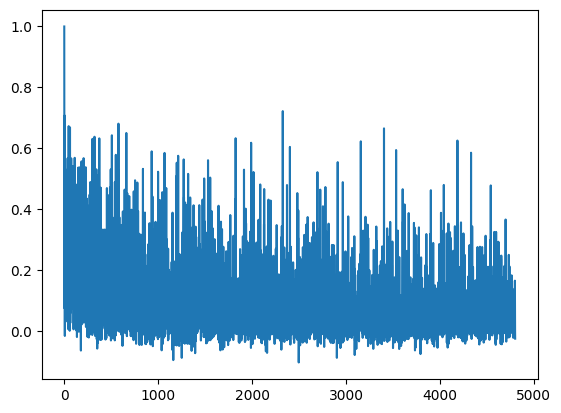

In [78]:
scores = scores.flatten()
print(scores.shape)
plt.plot(scores)

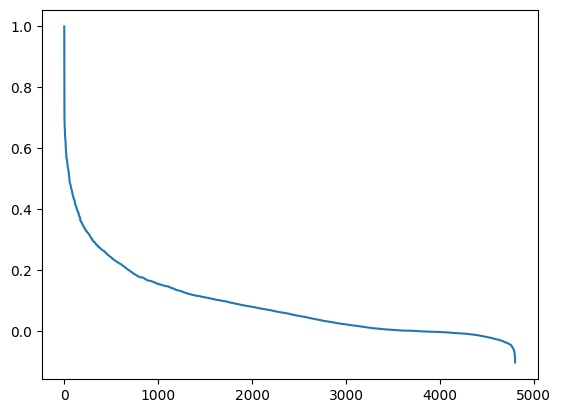

In [79]:
#sort in descenting order
(-scores).argsort()
plt.plot(scores[(-scores).argsort()])

In [65]:
#get top 5 matches, exclude self
recommended = (-scores).argsort()[1:6]
#convert them to titles again
df['original_title'].iloc[recommended]

2327                      Predator
4                      John Carter
577        AVP: Alien vs. Predator
3405    Stargate: The Ark of Truth
47         Star Trek Into Darkness
Name: original_title, dtype: object

In [80]:
#make it a function
def recommend_movie(title):
    idx = movie2idx[title]
    if type(idx) == pd.Series:
        idx = idx.iloc[0]
    query = Z[idx]
    query = np.expand_dims(query, axis=0)
    scores = cosine_similarity(query,Z)
    scores = scores.flatten()
    recommended = (-scores).argsort()[1:6]

    return df['original_title'].iloc[recommended]

recommend_movie('Cargo')

3427        The Andromeda Strain
922                      Knowing
2891    The Life Before Her Eyes
4221                  Spellbound
4733                 Open Secret
Name: original_title, dtype: object